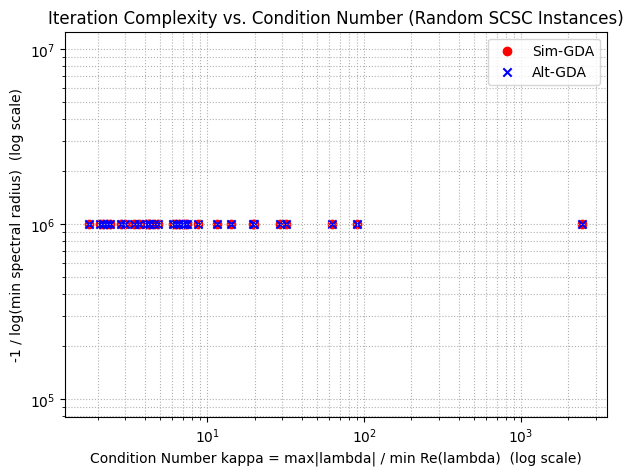

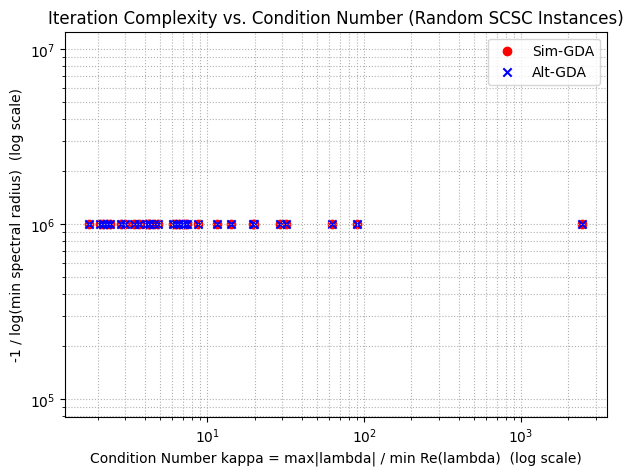

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# ============ 1. 随机生成 (A,B,C) 并计算 Jacobian J = [[A, B], [-B^T, C]] 的特征值 ============

def random_scsc_jacobian(d=5, seed=None):
    """
    随机生成一个 d 维的强凸-强凹近似矩阵 A, C 和耦合矩阵 B, 
    形成 J = [[A, B], [-B.T, C]].
    
    返回:
    - J: 2d x 2d 的 numpy 数组
    - lam: J 的特征值数组
    - kappa: 通过 max|lam| / min Re(lam) 定义的 condition number
    """
    if seed is not None:
        np.random.seed(seed)
    
    # 让 A, C 有一些“正/负对角”来体现强凸和强凹。
    # 这里做一个简单处理：A ~ diag( a_i ), C ~ - diag( c_i ), 再加点随机扰动。
    
    # 正对角分量 (强凸)
    diagA = np.diag( np.random.uniform(low=0.5, high=2.0, size=d) )
    # 负对角分量 (强凹)
    diagC = np.diag( - np.random.uniform(low=0.5, high=2.0, size=d) )
    
    # 给它一点随机噪声
    randA = 0.1 * np.random.randn(d, d)
    randC = 0.1 * np.random.randn(d, d)
    
    A = diagA + (randA + randA.T)/2.0   # 做对称化
    C = diagC + (randC + randC.T)/2.0
    
    # B 矩阵: 耦合部分, 任意随机
    B = 0.3 * np.random.randn(d, d)    # scale 0.3随便定的
    
    # 拼装 J
    top = np.concatenate([A, B], axis=1)
    bot = np.concatenate([-B.T, C], axis=1)
    J   = np.concatenate([top, bot], axis=0)
    
    # 特征值
    lam = np.linalg.eigvals(J)
    
    # 定义 condition number:
    # max|lambda| / min Re(lambda), 需要保证有正实部(以保证强单调).
    reals = [x.real for x in lam if x.real > 1e-12]
    if len(reals) == 0:
        # 万一没有正实部，就说明这个 J 不满足“强凸-强凹”假设(或极其退化)
        # 返回一个 None
        return None, None, None
    
    max_abs = np.max(np.abs(lam))
    min_re  = np.min(reals)
    kappa   = max_abs / min_re
    
    return J, lam, kappa


# ============ 2. 定义两种算法的 迭代算子矩阵 ============

def sim_gda_matrix(J, eta):
    """
    Sim-GDA: M = I - eta * J
    如果维度是 2d x 2d, 返回 M 同维度。
    """
    d2 = J.shape[0]
    return np.eye(d2) - eta * J

def alt_gda_matrix(A, B, C, eta):
    """
    Alt-GDA 的迭代矩阵:
    
    [ I - eta*A,     - eta*B ]
    [ eta*B^T(...) ,  ...    ]
    
    其中 "eta*B^T(...)" 是公式中 B^T*(I - eta*A).
    全部拼起来返回一个 2d x 2d 矩阵。
    
    注意: 函数调用时你必须先分块提取 A,B,C,
         A,B,C 均为 d x d 矩阵。
    """
    d = A.shape[0]
    Id = np.eye(d)
    
    # 左上块: I - eta*A
    top_left  = Id - eta*A
    # 右上块: - eta * B
    top_right = - eta * B
    
    # 左下块:  eta * B^T * (I - eta*A)
    bot_left  = eta * (B.T @ top_left)
    # 右下块:  I - eta*C - eta^2 * B^T * B
    bot_right = (Id - eta*C) - eta**2 * (B.T @ B)
    
    # 拼起来
    top_block = np.concatenate([top_left, top_right], axis=1)
    bot_block = np.concatenate([bot_left, bot_right], axis=1)
    return np.concatenate([top_block, bot_block], axis=0)


# ============ 3. 对于一个 (A,B,C) 或者 (J), 搜索最优谱半径 ============

def minimal_spectral_radius_sim_gda(J, eta_candidates):
    """
    在给定的一维网格 eta_candidates 上, 计算
    rho( I - eta*J ) 的最小值, 并返回对应的 eta.
    """
    best_rho = 1e10
    best_eta = None
    for eta in eta_candidates:
        M = sim_gda_matrix(J, eta)
        rho = max(abs(np.linalg.eigvals(M)))
        if rho < best_rho:
            best_rho = rho
            best_eta = eta
    return best_eta, best_rho

def minimal_spectral_radius_alt_gda(A,B,C, eta_candidates):
    best_rho = 1e10
    best_eta = None
    for eta in eta_candidates:
        M = alt_gda_matrix(A,B,C, eta)
        rho = max(abs(np.linalg.eigvals(M)))
        if rho < best_rho:
            best_rho = rho
            best_eta = eta
    return best_eta, best_rho


# ============ 4. 主例程: 随机采样, 计算( kappa, iteration_complexity ), 画图 ============

def experiment_plot(n_exps=30, d=5, n_eta=100):
    """
    - n_exps: 做多少次随机样本
    - d: 矩阵大小 d x d
    - n_eta: 每次网格搜索多少个步长
    
    最终画出:
    1) x轴: kappa (对数),
    2) y轴: iteration complexity (对数).
    并对比 Sim-GDA & Alt-GDA.
    """
    sim_complexities = []
    alt_complexities = []
    kappa_values     = []
    
    # 给定步长搜索范围
    # 大多数文献里对 GDA 要求 eta < 1/(L) 之类, 这里可以略大一点看效果:
    eta_candidates = np.linspace(0.0, 2.0, n_eta)[1:]  # 避免 0
    
    for seed in range(n_exps):
        J, lam, kappa = random_scsc_jacobian(d=d, seed=seed)
        if J is None:
            # 生成到了退化例子, 跳过
            continue
        
        # 分块提取 A, B, C (每个 dxd), 方便 alt_gda_matrix 用:
        A = J[:d, :d]
        B = J[:d, d:]
        C = J[d:, d:]
        
        # 找 Sim-GDA 的最优谱半径
        _, rho_sim = minimal_spectral_radius_sim_gda(J, eta_candidates)
        
        # 找 Alt-GDA 的最优谱半径
        _, rho_alt = minimal_spectral_radius_alt_gda(A,B,C, eta_candidates)
        
        # 定义“迭代复杂度”的度量, 比如 -1 / log(rho)
        # 如果 rho >= 1, 则视为非常大(收敛不了)
        def complexity(r):
            if r >= 1.0:
                return 1e6
            else:
                return -1.0 / np.log(r)  # 越大越慢
        
        comp_sim = complexity(rho_sim)
        comp_alt = complexity(rho_alt)
        
        sim_complexities.append(comp_sim)
        alt_complexities.append(comp_alt)
        kappa_values.append(kappa)
    
    # 转成 array
    sim_complexities = np.array(sim_complexities)
    alt_complexities = np.array(alt_complexities)
    kappa_values     = np.array(kappa_values)
    
    # 画图
    plt.figure(figsize=(7,5))
    plt.title("Iteration Complexity vs. Condition Number (Random SCSC Instances)")
    plt.scatter(kappa_values, sim_complexities, c='red',  marker='o', label='Sim-GDA')
    plt.scatter(kappa_values, alt_complexities, c='blue', marker='x', label='Alt-GDA')
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Condition Number kappa = max|lambda| / min Re(lambda)  (log scale)")
    plt.ylabel("-1 / log(min spectral radius)  (log scale)")
    plt.grid(True, which='both', ls=':')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    experiment_plot(n_exps=30, d=5, n_eta=100)


处理scale=0.10
  条件数κ=7392.29, Sim-GDA谱半径=1.002957, Alt-GDA谱半径=0.979377
处理scale=0.17
  条件数κ=888.21, Sim-GDA谱半径=1.000414, Alt-GDA谱半径=0.987144
处理scale=0.28
  条件数κ=4063.70, Sim-GDA谱半径=1.000088, Alt-GDA谱半径=0.992282
处理scale=0.46
  条件数κ=6450.92, Sim-GDA谱半径=1.000027, Alt-GDA谱半径=0.995366
处理scale=0.77
  条件数κ=3976.80, Sim-GDA谱半径=1.000008, Alt-GDA谱半径=0.997218
处理scale=1.29
  条件数κ=7212.44, Sim-GDA谱半径=1.000003, Alt-GDA谱半径=0.998331
处理scale=2.15
  条件数κ=12415.39, Sim-GDA谱半径=1.000001, Alt-GDA谱半径=0.998999
处理scale=3.59
  条件数κ=20949.61, Sim-GDA谱半径=1.000000, Alt-GDA谱半径=0.999400
处理scale=5.99
  条件数κ=35091.68, Sim-GDA谱半径=1.000000, Alt-GDA谱半径=0.999640
处理scale=10.00
  条件数κ=58624.21, Sim-GDA谱半径=1.000000, Alt-GDA谱半径=0.999784


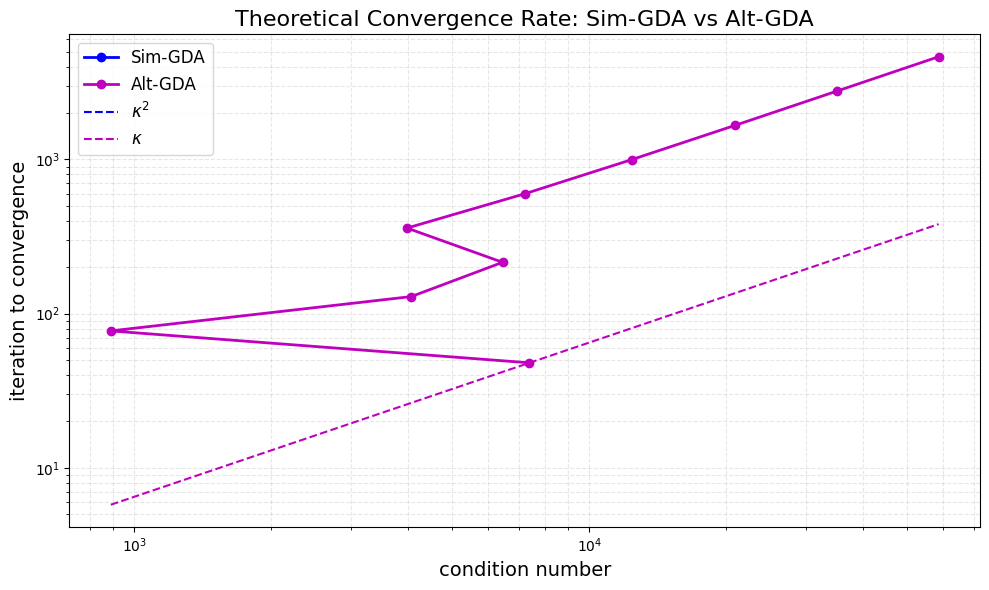

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigvals

def generate_quadratic_problem(d=100, scale=1.0):
    """生成二次极小极大问题"""
    eigenvalues = np.array([1/i for i in range(1, d+1)])
    A = np.diag(eigenvalues)
    C = np.diag(eigenvalues)
    
    # 生成B矩阵，控制条件数
    np.random.seed(42)
    B = np.random.normal(0, scale, (d, d))
    
    return A, B, C

def compute_condition_number(A, B, C):
    """计算Jacobian矩阵的条件数"""
    J = np.block([
        [A, B],
        [-B.T, -C]
    ])
    eigs = eigvals(J)
    real_pos = np.real(eigs[np.real(eigs) > 1e-10])
    if len(real_pos) == 0:
        return float('inf')
    
    return np.max(np.abs(eigs)) / np.min(np.abs(real_pos))

def compute_sim_gda_spectral_radius(A, B, C, kappa):
    """计算Sim-GDA的最优谱半径"""
    mu = min(np.min(np.diag(A)), np.min(np.diag(C)))
    L = max(np.max(np.diag(A)), np.max(np.diag(C)), np.linalg.norm(B, 2))
    
    # 根据定理4的最优步长
    eta = mu / (2 * L**2)
    
    # 构建Sim-GDA的迭代矩阵
    J = np.block([
        [A, B],
        [-B.T, -C]
    ])
    I = np.eye(J.shape[0])
    
    # 计算谱半径
    return max(abs(eigvals(I - eta * J)))

def compute_alt_gda_spectral_radius(A, B, C, kappa):
    """计算Alt-GDA的最优谱半径"""
    mu = min(np.min(np.diag(A)), np.min(np.diag(C)))
    L = max(np.max(np.diag(A)), np.max(np.diag(C)), np.linalg.norm(B, 2))
    
    # 根据推论1的最优步长
    eta = 1 / (2 * L)
    
    # 构建Alt-GDA的迭代矩阵
    d = A.shape[0]
    I = np.eye(d)
    zero = np.zeros((d, d))
    
    # 根据公式(21)构建
    M1 = np.block([
        [I - eta * A, -eta * B],
        [zero, I]
    ])
    
    M2 = np.block([
        [I, zero],
        [eta * B.T, I - eta * C]
    ])
    
    # Alt-GDA迭代矩阵是M2 * M1
    alt_matrix = M2 @ M1
    
    # 计算谱半径
    return max(abs(eigvals(alt_matrix)))

def main():
    d = 50  # 使用较小维度加速计算
    
    # 生成不同条件数的问题
    scales = np.logspace(-1, 1, 10)
    kappas = []
    sim_gda_radii = []
    alt_gda_radii = []
    
    for scale in scales:
        print(f"处理scale={scale:.2f}")
        A, B, C = generate_quadratic_problem(d, scale)
        kappa = compute_condition_number(A, B, C)
        kappas.append(kappa)
        
        # 计算谱半径
        rho_sim = compute_sim_gda_spectral_radius(A, B, C, kappa)
        rho_alt = compute_alt_gda_spectral_radius(A, B, C, kappa)
        
        sim_gda_radii.append(rho_sim)
        alt_gda_radii.append(rho_alt)
        
        print(f"  条件数κ={kappa:.2f}, Sim-GDA谱半径={rho_sim:.6f}, Alt-GDA谱半径={rho_alt:.6f}")
    
    # 计算-1/log(ρ)
    sim_gda_iters = [-1/np.log(r) for r in sim_gda_radii]
    alt_gda_iters = [-1/np.log(r) for r in alt_gda_radii]
    
    # 绘制图表
    plt.figure(figsize=(10, 6))
    
    plt.loglog(kappas, sim_gda_iters, 'bo-', linewidth=2, label='Sim-GDA')
    plt.loglog(kappas, alt_gda_iters, 'mo-', linewidth=2, label='Alt-GDA')
    
    # 添加理论参考线
    k_range = np.logspace(np.log10(min(kappas)), np.log10(max(kappas)), 100)
    c_sim = sim_gda_iters[0] / (kappas[0]**2)
    c_alt = alt_gda_iters[0] / kappas[0]
    
    plt.loglog(k_range, c_sim * k_range**2, 'b--', linewidth=1.5, label='$κ^2$')
    plt.loglog(k_range, c_alt * k_range, 'm--', linewidth=1.5, label='$κ$')
    
    plt.xlabel('condition number', fontsize=14)
    plt.ylabel('iteration to convergence', fontsize=14)
    plt.title('Theoretical Convergence Rate: Sim-GDA vs Alt-GDA', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, which="both", ls="--", alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('theoretical_convergence.png', dpi=300)
    plt.show()

if __name__ == "__main__":
    main()